In [35]:
import os
from time import time
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device('cuda:0')
print("CUDA:", USE_CUDA, DEVICE)

from tensorboardX import SummaryWriter
sw = SummaryWriter(logdir='.', flush_secs=5)

import math
from typing import Optional, List, Union

import torch
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F

from torch_geometric.data import Data
from torch_geometric.typing import OptTensor
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.transforms import LaplacianLambdaMax
from torch_geometric.utils import remove_self_loops, add_self_loops, get_laplacian
from torch_geometric.utils import to_dense_adj

CUDA: True cuda:0


In [2]:
from torch_geometric_temporal.nn.attention import ASTGCN

In [10]:
def load_graphdata_channel1(graph_signal_matrix_filename, num_of_hours, num_of_days, num_of_weeks, batch_size,
                            shuffle=True, DEVICE = torch.device('cuda:0')):
    '''
    :param graph_signal_matrix_filename: str
    :param num_of_hours: int
    :param num_of_days: int
    :param num_of_weeks: int
    :param DEVICE:
    :param batch_size: int
    :return:
    three DataLoaders, each dataloader contains:
    test_x_tensor: (B, N_nodes, in_feature, T_input)
    test_decoder_input_tensor: (B, N_nodes, T_output)
    test_target_tensor: (B, N_nodes, T_output)
    '''

    file = os.path.basename(graph_signal_matrix_filename).split('.')[0]
    filename = r'C:\Users\srush\bike share model\JC_ASTGCN\your_data_r1_d0_w0_astcgn'
    print('load file:', filename)

    file_data = np.load(filename + '.npz')
    train_x = file_data['train_x']  # (10181, 307, 2, 12)
    train_x = train_x[:, :, 0:1, :]
    train_target = file_data['train_target']  # (10181, 307, 12)

    val_x = file_data['val_x']
    val_x = val_x[:, :, 0:1, :]
    val_target = file_data['val_target']

    test_x = file_data['test_x']
    test_x = test_x[:, :, 0:1, :]
    test_target = file_data['test_target']

    mean = file_data['mean'][:, :, 0:1, :]  # (1, 1, 2, 1)
    std = file_data['std'][:, :, 0:1, :]  # (1, 1, 2, 1)

    # ------- train_loader -------
    train_x_tensor = torch.from_numpy(train_x).type(torch.FloatTensor).to(DEVICE)  # (B, N, F, T)
    train_target_tensor = torch.from_numpy(train_target).type(torch.FloatTensor).to(DEVICE)  # (B, N, T)
    train_dataset = torch.utils.data.TensorDataset(train_x_tensor, train_target_tensor)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)

    # ------- val_loader -------
    val_x_tensor = torch.from_numpy(val_x).type(torch.FloatTensor).to(DEVICE)  # (B, N, F, T)
    val_target_tensor = torch.from_numpy(val_target).type(torch.FloatTensor).to(DEVICE)  # (B, N, T)
    val_dataset = torch.utils.data.TensorDataset(val_x_tensor, val_target_tensor)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # ------- test_loader -------
    test_x_tensor = torch.from_numpy(test_x).type(torch.FloatTensor).to(DEVICE)  # (B, N, F, T)
    test_target_tensor = torch.from_numpy(test_target).type(torch.FloatTensor).to(DEVICE)  # (B, N, T)
    test_dataset = torch.utils.data.TensorDataset(test_x_tensor, test_target_tensor)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # print
    print('train:', train_x_tensor.size(), train_target_tensor.size())
    print('val:', val_x_tensor.size(), val_target_tensor.size())
    print('test:', test_x_tensor.size(), test_target_tensor.size())

    return train_loader, train_target_tensor, val_loader, val_target_tensor, test_loader, test_target_tensor, mean, std


In [11]:
graph_signal_matrix_filename = r'C:\Users\srush\bike share model\cleaned&merged_data\your_data.npz'
batch_size = 32
num_of_weeks = 0
num_of_days = 0
num_of_hours = 1

train_loader, train_target_tensor, val_loader, val_target_tensor, test_loader, test_target_tensor, _mean, _std = load_graphdata_channel1(
    graph_signal_matrix_filename, num_of_hours, num_of_days, num_of_weeks, batch_size)

load file: C:\Users\srush\bike share model\JC_ASTGCN\your_data_r1_d0_w0_astcgn
train: torch.Size([10181, 41, 1, 12]) torch.Size([10181, 41, 12])
val: torch.Size([3394, 41, 1, 12]) torch.Size([3394, 41, 12])
test: torch.Size([3394, 41, 1, 12]) torch.Size([3394, 41, 12])


### Loading Graph Data

In [12]:
weighted_adj_matrix_path = os.path.join('distances23.csv')
W = pd.read_csv(weighted_adj_matrix_path).drop('station_id', axis=1)

In [13]:
W.head()

,JC002,JC006,JC008,JC009,JC013,JC014,JC018,JC019,JC020,JC022,...,JC082,JC093,JC094,JC098,JC099,JC102,JC103,JC104,JC105,JC106
0,0.000000,862.390425,1625.689845,1743.424513,783.490505,654.002431,3183.259192,2768.274737,2793.263492,3049.868365,...,1147.096807,3485.330406,3497.100991,1137.145909,1584.798525,366.650465,3266.028073,570.943831,2597.358186,308.216283
1,862.390425,0.000000,983.590390,887.897228,829.916456,309.043702,2374.718420,1986.963363,2225.727518,2192.931991,...,413.399964,2905.804649,2875.282886,411.156217,1110.418606,662.139841,2490.121280,381.744340,1734.985691,646.135587
2,1625.689845,983.590390,0.000000,1033.857542,1813.337775,1282.046512,2414.033285,2163.628662,2768.208984,1976.207011,...,1203.681469,3378.138104,3288.541670,572.517191,1902.189648,1579.665788,2622.648652,1068.391227,1442.482131,1320.486463
3,1743.424513,887.897228,1033.857542,0.000000,1446.949083,1113.296017,1525.829341,1189.529177,1739.692627,1306.504370,...,667.591732,2344.815830,2260.283609,824.972685,1070.331741,1485.302157,1681.573014,1251.781905,877.597494,1531.426159
4,783.490505,829.916456,1813.337775,1446.949083,0.000000,538.823503,2663.034673,2219.127615,2065.553649,2676.879836,...,784.316047,2751.150405,2783.724150,1240.821567,874.265343,437.924485,2692.030016,890.664949,2316.128958,880.610935


In [15]:
W.drop('JC106', axis=1, inplace=True)

In [20]:
distance_mx = W.values

In [22]:
adj_mx = np.load('adjacency_matrix.npy')

In [25]:
num_of_vertices = 41

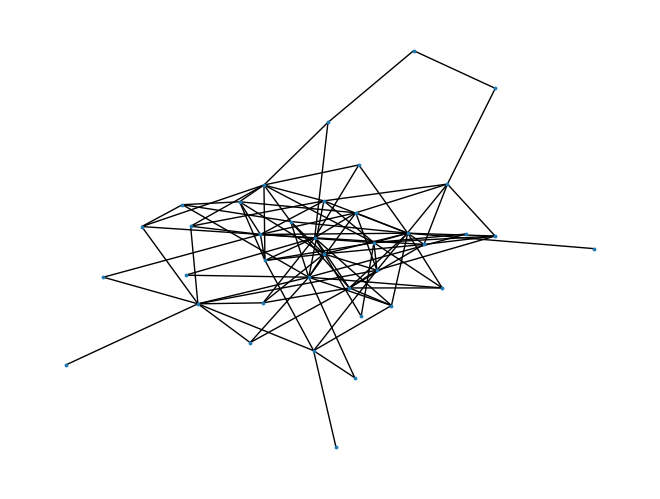

In [23]:
rows, cols = np.where(adj_mx == 1)
edges = zip(rows.tolist(), cols.tolist())
gr = nx.Graph()
gr.add_edges_from(edges)
nx.draw(gr, node_size=3)
plt.show()
rows, cols = np.where(adj_mx == 1)
edges = zip(rows.tolist(), cols.tolist())
edge_index_data = torch.LongTensor(np.array([rows, cols])).to(DEVICE)

In [26]:
nb_block = 2
in_channels = 1
K = 3
nb_chev_filter = 64
nb_time_filter = 64
time_strides = num_of_hours
num_for_predict = 12
len_input = 12
#L_tilde = scaled_Laplacian(adj_mx)
#cheb_polynomials = [torch.from_numpy(i).type(torch.FloatTensor).to(DEVICE) for i in cheb_polynomial(L_tilde, K)]
net = ASTGCN( nb_block, in_channels, K, nb_chev_filter, nb_time_filter, time_strides, num_for_predict, len_input, num_of_vertices).to(DEVICE)

print(net)

ASTGCN(
  (_blocklist): ModuleList(
    (0): ASTGCNBlock(
      (_temporal_attention): TemporalAttention()
      (_spatial_attention): SpatialAttention()
      (_chebconv_attention): ChebConvAttention(1, 64, K=3, normalization=None)
      (_time_convolution): Conv2d(64, 64, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
      (_residual_convolution): Conv2d(1, 64, kernel_size=(1, 1), stride=(1, 1))
      (_layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
    (1): ASTGCNBlock(
      (_temporal_attention): TemporalAttention()
      (_spatial_attention): SpatialAttention()
      (_chebconv_attention): ChebConvAttention(64, 64, K=3, normalization=None)
      (_time_convolution): Conv2d(64, 64, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
      (_residual_convolution): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (_layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
  )
  (_final_conv): Conv2d(12, 12, kernel_size=(1, 64), strid

In [27]:
learning_rate = 0.001
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

print('Net\'s state_dict:')
total_param = 0
for param_tensor in net.state_dict():
    print(param_tensor, '\t', net.state_dict()[param_tensor].size(), '\t', net.state_dict()[param_tensor].device)
    total_param += np.prod(net.state_dict()[param_tensor].size())
print('Net\'s total params:', total_param)
#--------------------------------------------------
print('Optimizer\'s state_dict:')
for var_name in optimizer.state_dict():
    print(var_name, '\t', optimizer.state_dict()[var_name])

Net's state_dict:
_blocklist.0._temporal_attention._U1 	 torch.Size([41]) 	 cuda:0
_blocklist.0._temporal_attention._U2 	 torch.Size([1, 41]) 	 cuda:0
_blocklist.0._temporal_attention._U3 	 torch.Size([1]) 	 cuda:0
_blocklist.0._temporal_attention._be 	 torch.Size([1, 12, 12]) 	 cuda:0
_blocklist.0._temporal_attention._Ve 	 torch.Size([12, 12]) 	 cuda:0
_blocklist.0._spatial_attention._W1 	 torch.Size([12]) 	 cuda:0
_blocklist.0._spatial_attention._W2 	 torch.Size([1, 12]) 	 cuda:0
_blocklist.0._spatial_attention._W3 	 torch.Size([1]) 	 cuda:0
_blocklist.0._spatial_attention._bs 	 torch.Size([1, 41, 41]) 	 cuda:0
_blocklist.0._spatial_attention._Vs 	 torch.Size([41, 41]) 	 cuda:0
_blocklist.0._chebconv_attention._weight 	 torch.Size([3, 1, 64]) 	 cuda:0
_blocklist.0._chebconv_attention._bias 	 torch.Size([64]) 	 cuda:0
_blocklist.0._time_convolution.weight 	 torch.Size([64, 64, 1, 3]) 	 cuda:0
_blocklist.0._time_convolution.bias 	 torch.Size([64]) 	 cuda:0
_blocklist.0._residual_convol

## Loss Function

In [28]:
# masked mae
def masked_mae(preds, labels, null_val=np.nan):
    if np.isnan(null_val):
        mask = ~torch.isnan(labels)
    else:
        mask = (labels != null_val)
    mask = mask.float()
    mask /= torch.mean((mask))
    mask = torch.where(torch.isnan(mask), torch.zeros_like(mask), mask)
    loss = torch.abs(preds - labels)
    loss = loss * mask
    loss = torch.where(torch.isnan(loss), torch.zeros_like(loss), loss)
    return torch.mean(loss)

In [29]:
masked_flag=0
criterion = nn.L1Loss().to(DEVICE)
criterion_masked = masked_mae
loss_function = 'mse'

metric_method = 'unmask'
missing_value=0.0


if loss_function=='masked_mse':
    criterion_masked = masked_mse         #nn.MSELoss().to(DEVICE)
    masked_flag=1
elif loss_function=='masked_mae':
    criterion_masked = masked_mae
    masked_flag = 1
elif loss_function == 'mae':
    criterion = nn.L1Loss().to(DEVICE)
    masked_flag = 0
elif loss_function == 'rmse':
    criterion = nn.MSELoss().to(DEVICE)
    masked_flag= 0

In [30]:
def compute_val_loss_mstgcn(net, val_loader, criterion,  masked_flag,missing_value,sw, epoch, edge_index_data, limit=None):
    '''
    for rnn, compute mean loss on validation set
    :param net: model
    :param val_loader: torch.utils.data.utils.DataLoader
    :param criterion: torch.nn.MSELoss
    :param sw: tensorboardX.SummaryWriter
    :param global_step: int, current global_step
    :param limit: int,
    :return: val_loss
    '''
    net.train(False)  # ensure dropout layers are in evaluation mode
    with torch.no_grad():
        val_loader_length = len(val_loader)  # nb of batch
        tmp = []  # batch loss
        for batch_index, batch_data in enumerate(val_loader):
            encoder_inputs, labels = batch_data
            outputs = net(encoder_inputs, edge_index_data)
            if masked_flag:
                loss = criterion(outputs, labels, missing_value)
            else:
                loss = criterion(outputs, labels)
            tmp.append(loss.item())
            if batch_index % 100 == 0:
                print('validation batch %s / %s, loss: %.2f' % (batch_index + 1, val_loader_length, loss.item()))
            if (limit is not None) and batch_index >= limit:
                break

        validation_loss = sum(tmp) / len(tmp)
        sw.add_scalar('validation_loss', validation_loss, epoch)
    return validation_loss

In [31]:
global_step = 0
best_epoch = 0
best_val_loss = np.inf
start_time= time()

In [36]:
# train model
for epoch in range(20):
    params_filename = os.path.join('./', 'epoch_%s.params' % epoch)
    masked_flag = 1
    if masked_flag:
        val_loss = compute_val_loss_mstgcn(net, val_loader, criterion_masked, masked_flag,missing_value,sw, epoch,edge_index_data)
    else:
        val_loss = compute_val_loss_mstgcn(net, val_loader, criterion, masked_flag, missing_value, sw, epoch,edge_index_data)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
        torch.save(net.state_dict(), params_filename)
        print('save parameters to file: %s' % params_filename)

    net.train()  # ensure dropout layers are in train mode

    for batch_index, batch_data in enumerate(train_loader):
        encoder_inputs, labels = batch_data   # encoder_inputs torch.Size([32, 307, 1, 12])  label torch.Size([32, 307, 12])
        optimizer.zero_grad()
        outputs = net(encoder_inputs, edge_index_data) # torch.Size([32, 307, 12])

        if masked_flag:
            loss = criterion_masked(outputs, labels,missing_value)
        else :
            loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        training_loss = loss.item()
        global_step += 1
        sw.add_scalar('training_loss', training_loss, global_step)

        if global_step % 200 == 0:
            print('global step: %s, training loss: %.2f, time: %.2fs' % (global_step, training_loss, time() - start_time))

validation batch 1 / 107, loss: 0.79
validation batch 101 / 107, loss: 1.06
save parameters to file: ./epoch_0.params
global step: 200, training loss: 0.17, time: 301.28s
validation batch 1 / 107, loss: 0.05
validation batch 101 / 107, loss: 0.41
save parameters to file: ./epoch_1.params
global step: 400, training loss: 0.16, time: 325.00s
global step: 600, training loss: 0.19, time: 342.85s
validation batch 1 / 107, loss: 0.06
validation batch 101 / 107, loss: 0.42
global step: 800, training loss: 0.12, time: 365.55s
validation batch 1 / 107, loss: 0.05
validation batch 101 / 107, loss: 0.41
global step: 1000, training loss: 0.16, time: 388.36s
global step: 1200, training loss: 0.15, time: 406.29s
validation batch 1 / 107, loss: 0.04
validation batch 101 / 107, loss: 0.41
save parameters to file: ./epoch_4.params
global step: 1400, training loss: 0.13, time: 428.22s
validation batch 1 / 107, loss: 0.04
validation batch 101 / 107, loss: 0.41
global step: 1600, training loss: 0.13, time

In [37]:
net.train(False)  # ensure dropout layers are in evaluation mode
with torch.no_grad():
    test_loader_length = len(test_loader)  # nb of batch
    tmp = []  # batch loss
    for batch_index, batch_data in enumerate(test_loader):
        encoder_inputs, labels = batch_data
        outputs = net(encoder_inputs, edge_index_data)
        loss = criterion(outputs, labels)
        tmp.append(loss.item())
        if batch_index % 100 == 0:
            print('test_loss batch %s / %s, loss: %.2f' % (batch_index + 1, test_loader_length, loss.item()))


    test_loss = sum(tmp) / len(tmp)
    sw.add_scalar('test_loss', test_loss, epoch)
print(test_loss)

test_loss batch 1 / 107, loss: 0.97
test_loss batch 101 / 107, loss: 0.95
0.9600670593921269


In [38]:
sample_output = outputs[0]  # prediction
sample_labels = labels[0] # truth
print(sample_output.shape, sample_labels.shape)

torch.Size([41, 12]) torch.Size([41, 12])


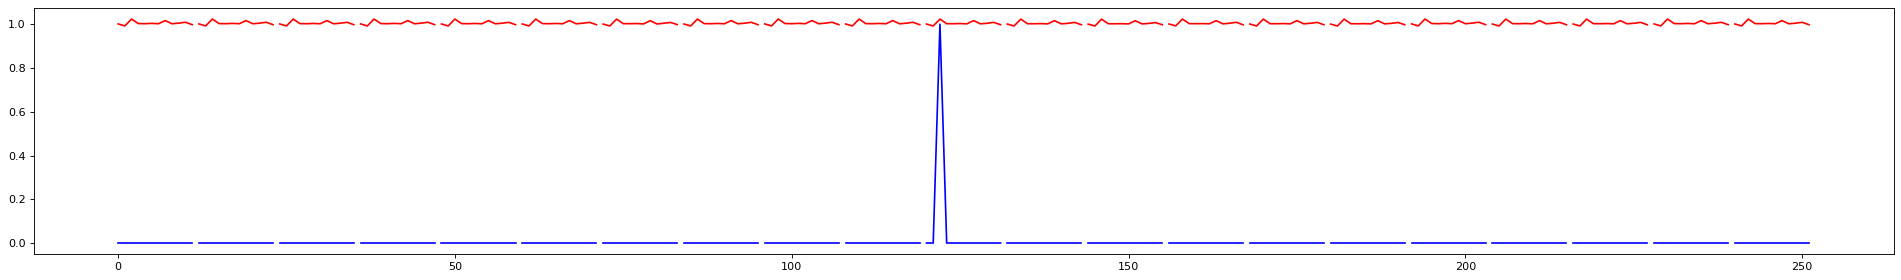

In [42]:
from matplotlib.pyplot import figure

figure(figsize=(30,4), dpi=80)
max_length = min(len(sample_output), len(sample_labels))
for i in range(min(21, max_length)):
    new_i = i * 12
    plt.plot(range(0+new_i,12+new_i),sample_output[i].detach().cpu().numpy(), color = 'red')
    plt.plot(range(0+new_i,12+new_i),sample_labels[i].cpu().numpy(), color='blue')
plt.show()